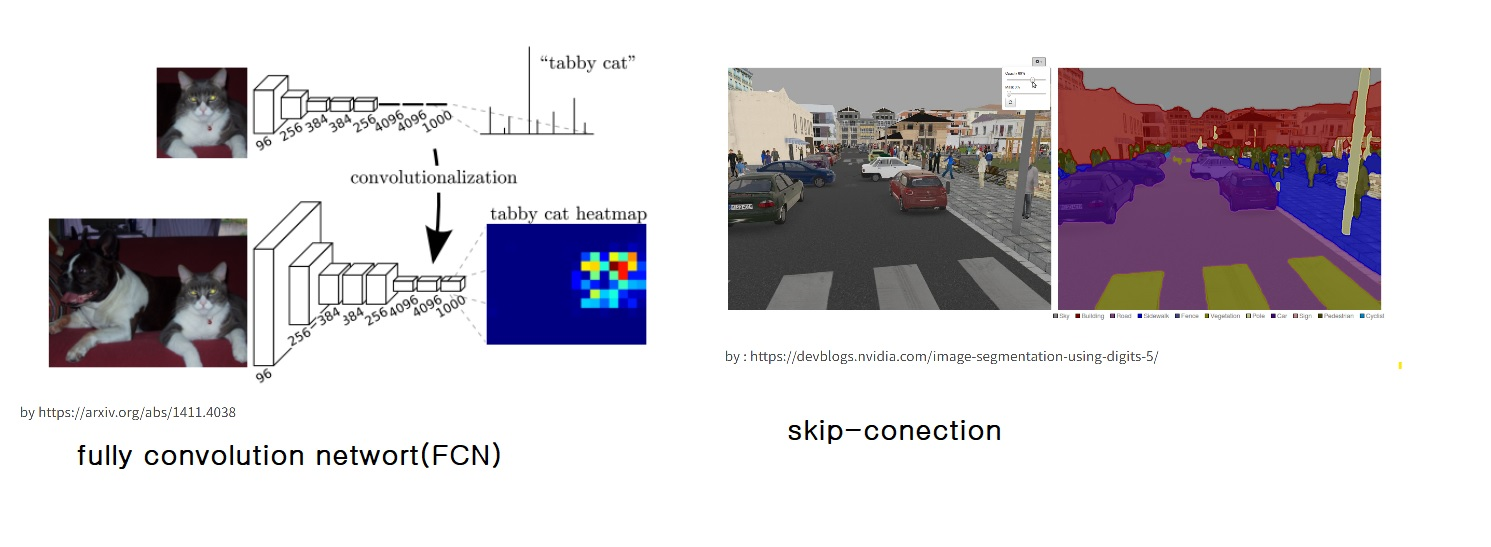

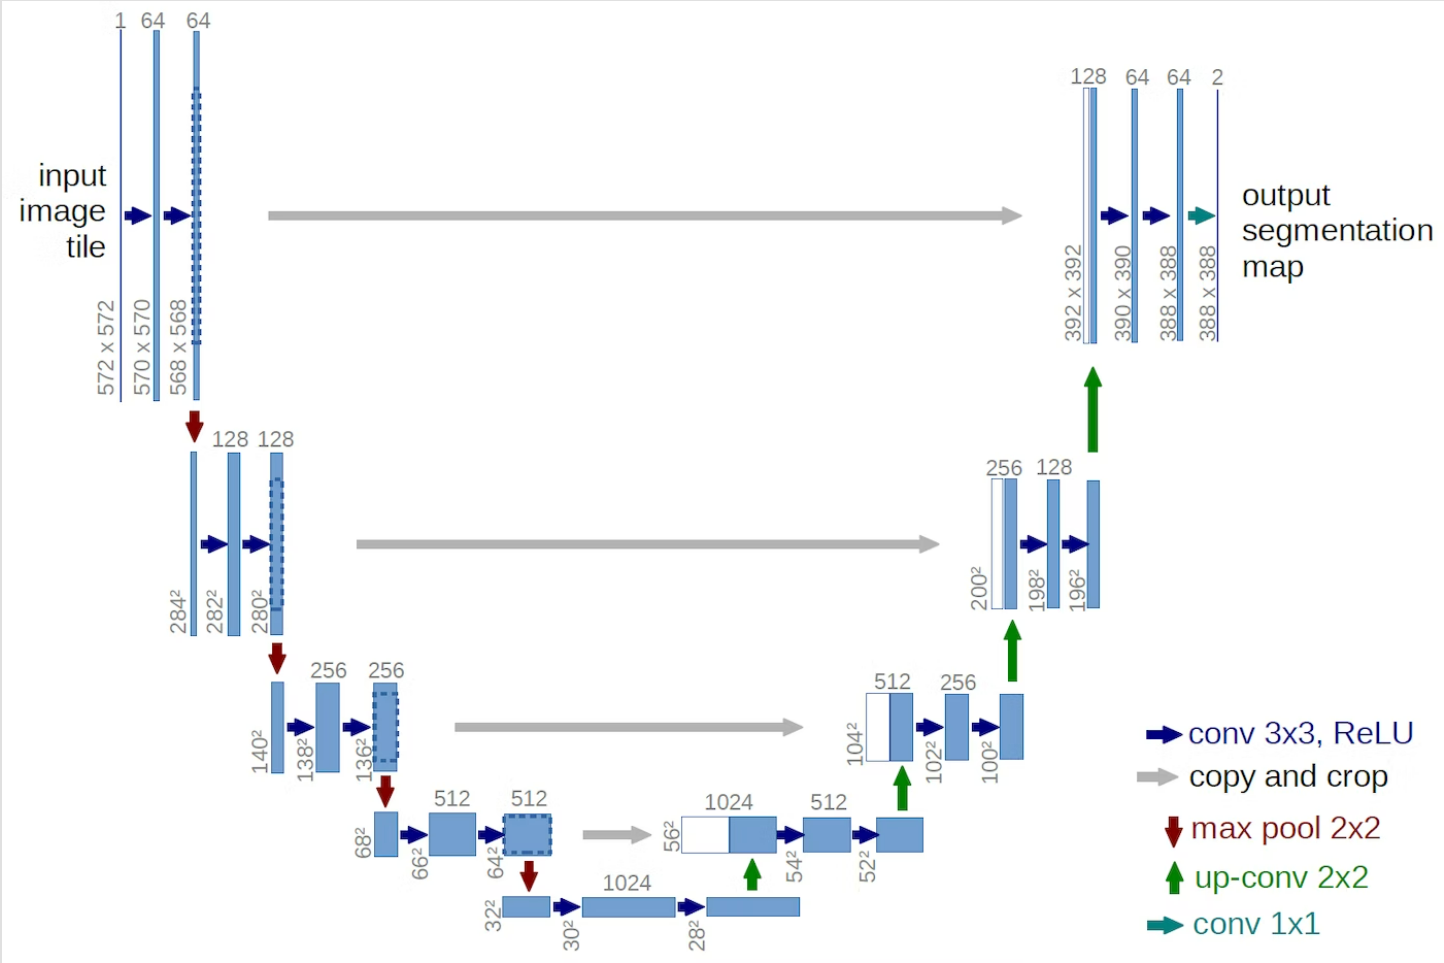

In [30]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation , Conv2DTranspose , concatenate , Cropping2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np



def unet_model(input_size=(572,572,1)):
        inputs = Input(input_size)
        
        #Encoder(downsampling)
        conv1 = Conv2D(64,3,activation='relu',padding='valid')(inputs)
        conv1 = Conv2D(64,3,activation='relu',padding='valid')(conv1)
        pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
        
        conv2 = Conv2D(128,3,activation='relu',padding='valid')(pool1)
        conv2 = Conv2D(128,3,activation='relu',padding='valid')(conv2)
        pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
        
        conv3 = Conv2D(256,3,activation='relu',padding='valid')(pool2)
        conv3 = Conv2D(256,3,activation='relu',padding='valid')(conv3)
        pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
        
        conv4 = Conv2D(512,3,activation='relu',padding='valid')(pool3)
        conv4 = Conv2D(512,3,activation='relu',padding='valid')(conv4)
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
                
        conv5 = Conv2D(1024,3,activation='relu',padding='valid')(pool4)
        conv5 = Conv2D(1024,3,activation='relu',padding='valid')(conv5)
        
        #Decoder(upsampling)
        
        up6 = Conv2DTranspose(512,2,strides=(2,2),padding='valid')(conv5)
        cropped_conv4  = Cropping2D(cropping=((4,4),(4,4)))(conv4)
        up6 = concatenate([up6,cropped_conv4],axis=3)
        conv6 = Conv2D(512,3,activation='relu',padding='valid')(up6)
        conv6 = Conv2D(512,3,activation='relu',padding='valid')(conv6)
        
        up7 = Conv2DTranspose(256,2,strides=(2,2),padding='valid')(conv6)
        cropped_conv3 = Cropping2D(cropping=((16,16),(16,16)))(conv3)
        up7 = concatenate([up7,cropped_conv3],axis=3)
        conv7 = Conv2D(256,3,activation='relu',padding='valid')(up7)
        conv7 = Conv2D(256,3,activation='relu',padding='valid')(conv7)
              
        up8 = Conv2DTranspose(128,2,strides=(2,2),padding='valid')(conv7)
        cropped_conv2 = Cropping2D(cropping=((40,40),(40,40)))(conv2)
        up8 = concatenate([up8,cropped_conv2],axis=3)
        conv8 = Conv2D(128,3,activation='relu',padding='valid')(up8)
        conv8 = Conv2D(128,3,activation='relu',padding='valid')(conv8)
        
        up9 = Conv2DTranspose(64,2,strides=(2,2),padding='valid')(conv8)
        cropped_conv1 = Cropping2D(cropping=((88,88),(88,88)))(conv1)
        up9 = concatenate([up9,cropped_conv1],axis=3)
        conv9 = Conv2D(64,3,activation='relu',padding='valid')(up9)
        conv9 = Conv2D(64,3,activation='relu',padding='valid')(conv9)
        
        
        conv10 = Conv2D(1,1,activation='sigmoid')(conv9)
        model = Model(inputs=[inputs],outputs=[conv10])
        return model
        
#모델 생성        
model = unet_model()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 572, 572, 1)]        0         []                            
                                                                                                  
 conv2d_342 (Conv2D)         (None, 570, 570, 64)         640       ['input_27[0][0]']            
                                                                                                  
 conv2d_343 (Conv2D)         (None, 568, 568, 64)         36928     ['conv2d_342[0][0]']          
                                                                                                  
 max_pooling2d_104 (MaxPool  (None, 284, 284, 64)         0         ['conv2d_343[0][0]']          
 ing2D)                                                                                      

 conv2d_358 (Conv2D)         (None, 390, 390, 64)         73792     ['concatenate_63[0][0]']      
                                                                                                  
 conv2d_359 (Conv2D)         (None, 388, 388, 64)         36928     ['conv2d_358[0][0]']          
                                                                                                  
 conv2d_360 (Conv2D)         (None, 388, 388, 1)          65        ['conv2d_359[0][0]']          
                                                                                                  
Total params: 31030593 (118.37 MB)
Trainable params: 31030593 (118.37 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [ ]:
#input_shape=[(None, 200, 200, 128), (None, 152, 152, 128)]
#128  = 64
# 80 = 40
# 32 = 16
# 64 = 32

###  Convolutional Autoencoder  256→128→64→32 :  32→64→128→256
#### Cifar10의 데이터로 다음을 구성해 보자 
    1. 간단한 컨벌루션 오토 엔코더
    2. 노이즈 제거 오토 엔코더
    3. UNET

#### Q1)  64→32→16으로 축소하고 디코더에서 16→32→64로 확대 ,간단한 컨벌루션 오토 엔코더

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

batch_size = 32
num_classes = 10
epochs = 5
saveDir = "/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)


#1-1.로드 데이터  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#1-2 normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_val = x_test[:7000]
x_test = x_test[7000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [2]:
#1-3 Convolutional AutoEncoder

#################### encoded
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)  
x = Activation('relu')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#################decoded
x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

model = Model(input_img, decoded) #AE 
model.compile(optimizer='adam', loss='binary_crossentropy')


In [3]:
#1-4 Train AutoEncoder
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#1-5모델 실행 
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)


Epoch 1/5

1563/1563 [==============================] - ETA: 0s - loss: 0.5829
Epoch 1: val_loss improved from inf to 0.57748, saving model to /ae\AutoEncoder_Cifar10_Deep_weights.01-0.58-0.58.hdf5
1563/1563 [==============================] - 103s 63ms/step - loss: 0.5829 - val_loss: 0.5775
Epoch 2/5


C:\Users\Dominica\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1562/1563 [============================>.] - ETA: 0s - loss: 0.5724
Epoch 2: val_loss improved from 0.57748 to 0.57129, saving model to /ae\AutoEncoder_Cifar10_Deep_weights.02-0.57-0.57.hdf5
1563/1563 [==============================] - 66s 42ms/step - loss: 0.5724 - val_loss: 0.5713
Epoch 3/5
1562/1563 [============================>.] - ETA: 0s - loss: 0.5695
Epoch 3: val_loss improved from 0.57129 to 0.57013, saving model to /ae\AutoEncoder_Cifar10_Deep_weights.03-0.57-0.57.hdf5
1563/1563 [==============================] - 86s 55ms/step - loss: 0.5695 - val_loss: 0.5701
Epoch 4/5
1562/1563 [============================>.] - ETA: 0s - loss: 0.5682
Epoch 4: val_loss improved from 0.57013 to 0.56713, saving model to /ae\AutoEncoder_Cifar10_Deep_weights.04-0.57-0.57.hdf5
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5682 - val_loss: 0.5671
Epoch 5/5
1563/1563 [==============================] - ETA: 0s - loss: 0.5672
Epoch 5: val_loss improved from 0.56713 to 0.56706

In [4]:
#1-6 예측
c10test = model.predict(x_test)
c10val = model.predict(x_val)
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

219/219 [==============================] - 3s 12ms/step
Cifar10_test: 0.4825151860713959
Cifar10_val: 0.4856279194355011


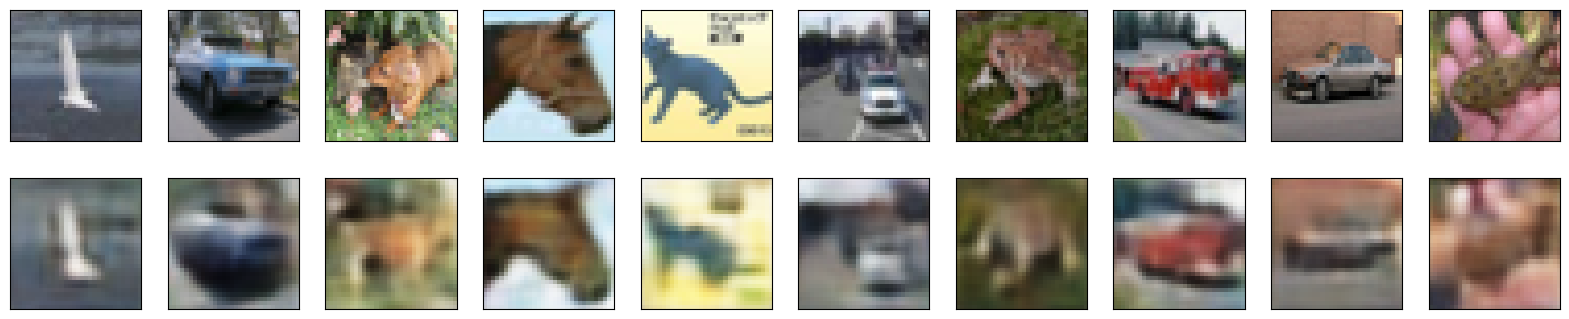

In [5]:
#1-7 시각화  
def show_img(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display 원본
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display 복원
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
show_img(x_test, c10test)

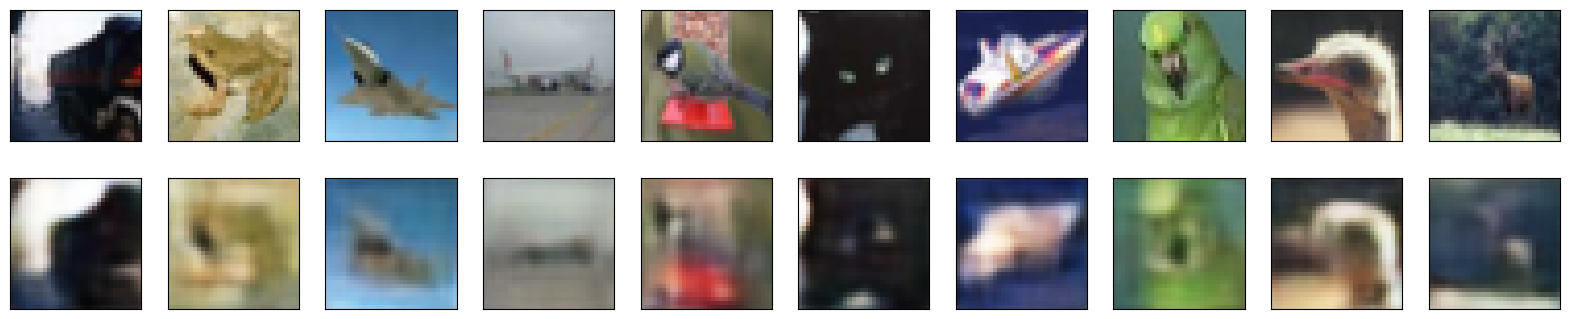

In [6]:
show_img(x_test[100:], c10test[100:])

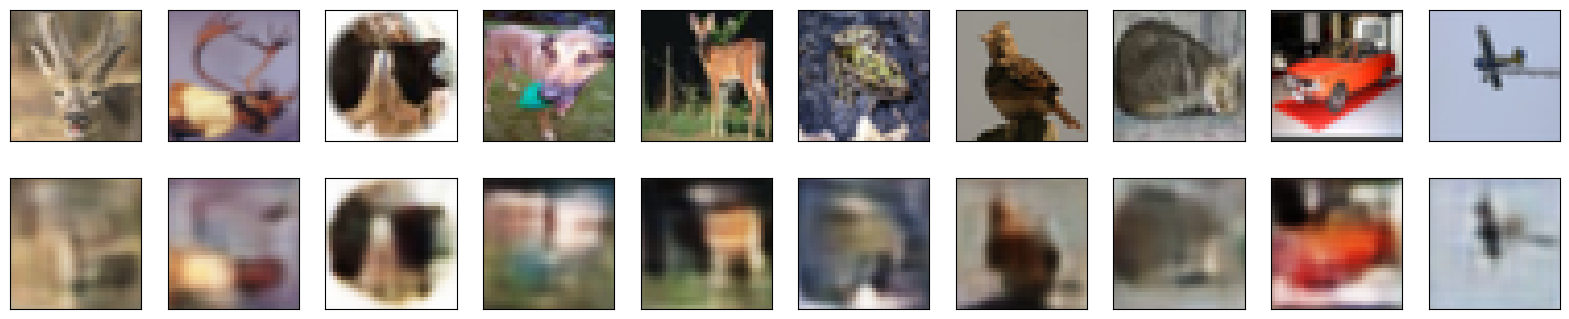

In [7]:
show_img(x_test[200:], c10test[200:])

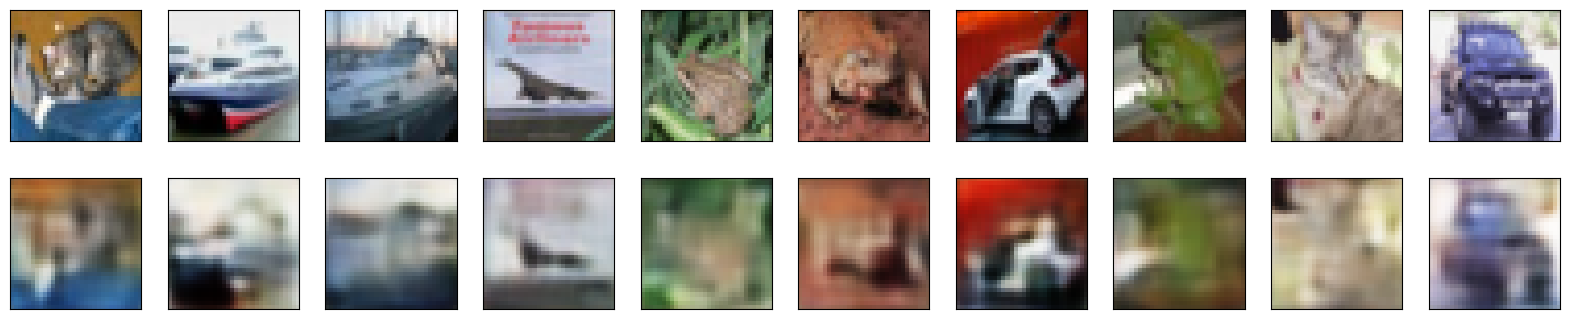

In [8]:
show_img(x_val, c10val)

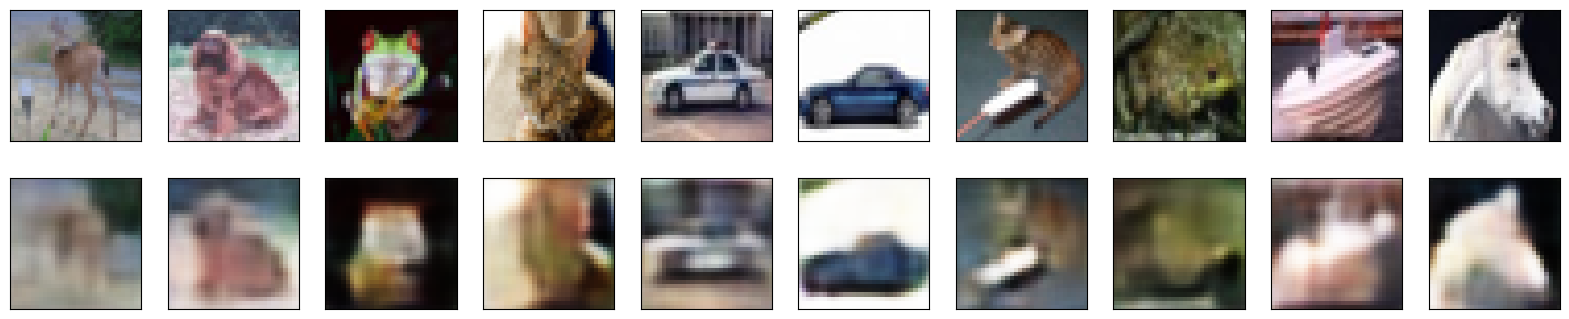

In [9]:
show_img(x_val[100:], c10val[100:])

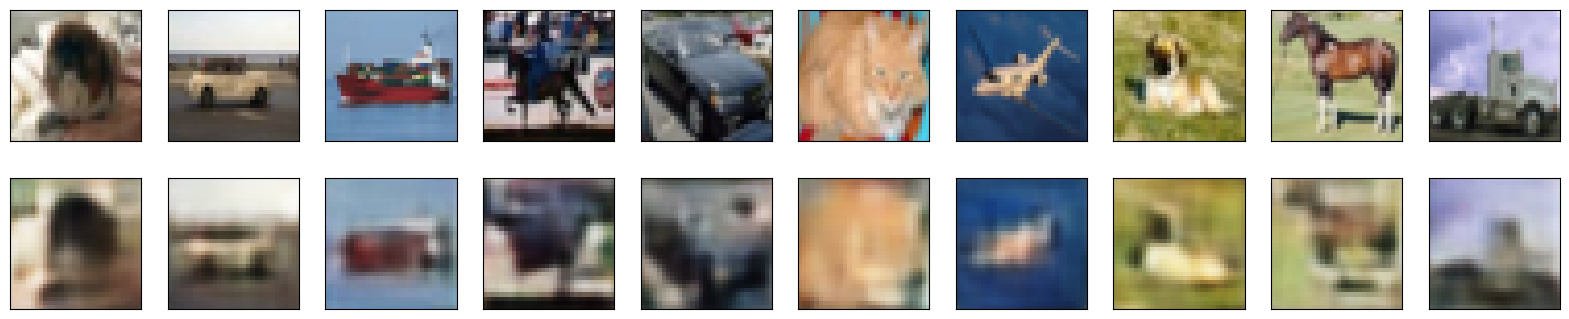

In [10]:
show_img(x_val[200:], c10val[200:])